#Build a Basic Neural Network using TensorFlow and Evaluate Metrics (Churn Dataset)

Objective:
To demonstrate how to build a basic feed-forward neural network using TensorFlow's Keras API for a binary classification task (customer churn prediction) and evaluate its performance using relevant metrics.

#Step-by-Step Guide with Code and Explanations:

1. Setup and Library Imports

In [26]:
import tensorflow as tf # Import the TensorFlow library, the core framework for building and training neural networks.
from tensorflow import keras # Import Keras API from TensorFlow, a high-level API for rapid prototyping and easy model building.
from tensorflow.keras import layers # Import layers module for defining different types of neural network layers (e.g., Dense).
from sklearn.model_selection import train_test_split # For splitting data into training and testing sets.
from sklearn.preprocessing import StandardScaler, OneHotEncoder # For scaling numerical features and encoding categorical features.
from sklearn.compose import ColumnTransformer # To apply different transformers to different columns.
from sklearn.pipeline import Pipeline # To create a pipeline for preprocessing and modeling.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report # Evaluation metrics for binary classification.
import numpy as np # For numerical operations.
import pandas as pd # For data manipulation, especially with DataFrames.
import matplotlib.pyplot as plt # For basic plotting.
import seaborn as sns # For enhanced statistical data visualizations, especially for confusion matrix.

print(f"TensorFlow Version: {tf.__version__}") # Print TensorFlow version to confirm installation.

TensorFlow Version: 2.18.0


2. Generate Synthetic Churn Dataset

We'll create a synthetic dataset that mimics common features found in customer churn datasets. This will involve both numerical and categorical features.

In [27]:
# Set a seed for reproducibility
np.random.seed(42)

# Number of customers
n_customers = 2000

# Generate synthetic data
data = {
    'customer_id': range(1, n_customers + 1),
    'gender': np.random.choice(['Male', 'Female'], n_customers),
    'senior_citizen': np.random.choice([0, 1], n_customers, p=[0.8, 0.2]), # 20% senior citizens
    'partner': np.random.choice(['Yes', 'No'], n_customers, p=[0.5, 0.5]),
    'dependents': np.random.choice(['Yes', 'No'], n_customers, p=[0.4, 0.6]),
    'tenure': np.random.randint(1, 72, n_customers), # Months customer has stayed
    'phone_service': np.random.choice(['Yes', 'No'], n_customers, p=[0.9, 0.1]),
    'multiple_lines': np.random.choice(['No', 'Yes', 'No phone service'], n_customers, p=[0.5, 0.4, 0.1]),
    'internet_service': np.random.choice(['DSL', 'Fiber optic', 'No'], n_customers, p=[0.3, 0.5, 0.2]),
    'monthly_charges': np.random.uniform(20, 120, n_customers),
    'contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_customers, p=[0.6, 0.2, 0.2]),
    'payment_method': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'], n_customers, p=[0.4, 0.2, 0.2, 0.2]),
}

df = pd.DataFrame(data)

# Simulate 'Total Charges' based on 'Tenure' and 'Monthly Charges'
df['total_charges'] = df['monthly_charges'] * df['tenure'] + np.random.normal(0, 10, n_customers)
df['total_charges'] = df['total_charges'].apply(lambda x: max(0, x)) # Ensure no negative values

# Simulate 'Churn' (target variable)
# Higher churn for: month-to-month contract, fiber optic internet, electronic check, low tenure, high monthly charges, senior citizen.
df['churn'] = 0 # Default to no churn

# Apply rules for churn
# Rule 1: Month-to-month contract + high monthly charges + fiber optic often churn
churn_rule1 = (df['contract'] == 'Month-to-month') & (df['monthly_charges'] > 80) & (df['internet_service'] == 'Fiber optic')
df.loc[churn_rule1, 'churn'] = np.random.choice([0, 1], size=churn_rule1.sum(), p=[0.3, 0.7])



In [28]:
# Rule 2: Electronic check + low tenure
churn_rule2 = (df['payment_method'] == 'Electronic check') & (df['tenure'] < 12)
df.loc[churn_rule2, 'churn'] = np.random.choice([0, 1], size=churn_rule2.sum(), p=[0.4, 0.6])

# Rule 3: Senior citizen + no partner/dependents
churn_rule3 = (df['senior_citizen'] == 1) & (df['partner'] == 'No') & (df['dependents'] == 'No')
df.loc[churn_rule3, 'churn'] = np.random.choice([0, 1], size=churn_rule3.sum(), p=[0.5, 0.5])

# Add some random churn
df['churn'] = df['churn'].apply(lambda x: 1 if np.random.rand() < 0.05 else x) # Base churn rate

# Convert 'churn' to integer (0 or 1)
df['churn'] = df['churn'].astype(int)

print("Synthetic Churn Dataset Head:")
print(df.head())
print(f"\nChurn distribution:\n{df['churn'].value_counts(normalize=True)}")

# Separate features (X) and target (y)
X = df.drop(['customer_id', 'churn'], axis=1)
y = df['churn']

Synthetic Churn Dataset Head:
   customer_id  gender  senior_citizen partner dependents  tenure  \
0            1    Male               0      No        Yes      57   
1            2  Female               0      No         No      27   
2            3    Male               1     Yes         No       5   
3            4    Male               0      No        Yes      71   
4            5    Male               1      No         No      57   

  phone_service    multiple_lines internet_service  monthly_charges  \
0           Yes               Yes              DSL        33.185199   
1           Yes                No      Fiber optic        70.768382   
2           Yes  No phone service              DSL        89.244035   
3           Yes               Yes      Fiber optic        83.018557   
4           Yes               Yes              DSL       100.375495   

         contract             payment_method  total_charges  churn  
0  Month-to-month  Bank transfer (automatic)    1898.102981

#3. Preprocess Data: Splitting and Feature Engineering
Neural networks perform best with scaled numerical features and one-hot encoded categorical features.

In [29]:
# Identify numerical and categorical features
numerical_features = ['tenure', 'monthly_charges', 'total_charges']
categorical_features = [col for col in X.columns if col not in numerical_features]

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Create a preprocessing pipeline
# This will apply StandardScaler to numerical features and OneHotEncoder to categorical features.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # handle_unknown='ignore' to handle new categories in test set gracefully
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining data shape before preprocessing: {X_train.shape}")
print(f"Testing data shape before preprocessing: {X_test.shape}")



Numerical features: ['tenure', 'monthly_charges', 'total_charges']
Categorical features: ['gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service', 'contract', 'payment_method']

Training data shape before preprocessing: (1600, 12)
Testing data shape before preprocessing: (400, 12)


In [30]:

# Fit and transform the training data, transform the test data
# This step applies the scaling and one-hot encoding.
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Training data shape after preprocessing: {X_train_processed.shape}")
print(f"Testing data shape after preprocessing: {X_test_processed.shape}")

# Get the number of input features for the neural network
input_features = X_train_processed.shape[1]
print(f"\nNumber of input features for the neural network: {input_features}")

Training data shape after preprocessing: (1600, 26)
Testing data shape after preprocessing: (400, 26)

Number of input features for the neural network: 26


#4. Build the Neural Network Model

For binary classification, the output layer will be a single neuron with a sigmoid activation function, and the loss function will be binary_crossentropy.

In [31]:
# Define the neural network model
model = keras.Sequential([
    # Input layer and first hidden layer
    # The number of units (neurons) in hidden layers is a hyperparameter; start with something reasonable.
    # 'relu' (Rectified Linear Unit) is a common activation for hidden layers.
    layers.Dense(units=32, activation='relu', input_shape=(input_features,)), # 32 neurons in the first hidden layer

    # Second hidden layer
    layers.Dense(units=16, activation='relu'), # 16 neurons in the second hidden layer

    # Output layer for binary classification
    # units=1: One neuron for binary output.
    # activation='sigmoid': Squashes the output to a value between 0 and 1, representing the probability of the positive class (churn).
    layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
# Configures the model for training.
model.compile(
    optimizer='adam', # Optimizer: 'adam' is a popular and generally effective choice.
    loss='binary_crossentropy', # Loss function: Used for binary classification when output is a probability.
    metrics=['accuracy', # Measures the percentage of correctly classified instances.
              tf.keras.metrics.Precision(), # Measures precision (TP / (TP + FP)).
              tf.keras.metrics.Recall()] # Measures recall (TP / (TP + FN)).
)

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409 (5.50 KB)

 Trainable params: 1,409 (5.50 KB)

 Non-trainable params: 0 (0.00 B)

#5. Train the Neural Network


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7368 - loss: 0.6011 - precision: 0.1754 - recall: 0.1240 - val_accuracy: 0.8292 - val_loss: 0.4690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8215 - loss: 0.4629 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8292 - val_loss: 0.4287 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8237 - loss: 0.4271 - precision: 0.2614 - recall: 0.0015 - val_accuracy: 0.8333 - val_loss: 0.4028 - val_precision: 1.0000 - val_recall: 0.0244
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8179 - loss: 0.4012 - precision: 0.2893 - recall: 0.0077 - val_accuracy: 0.8458 - val_loss: 0.3852 - val_precision: 0.7500 - val_recall: 0.1463
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8382 - loss: 0.3717 - precision: 0.7279 - recall: 0.0809 - val_accuracy: 0.8542

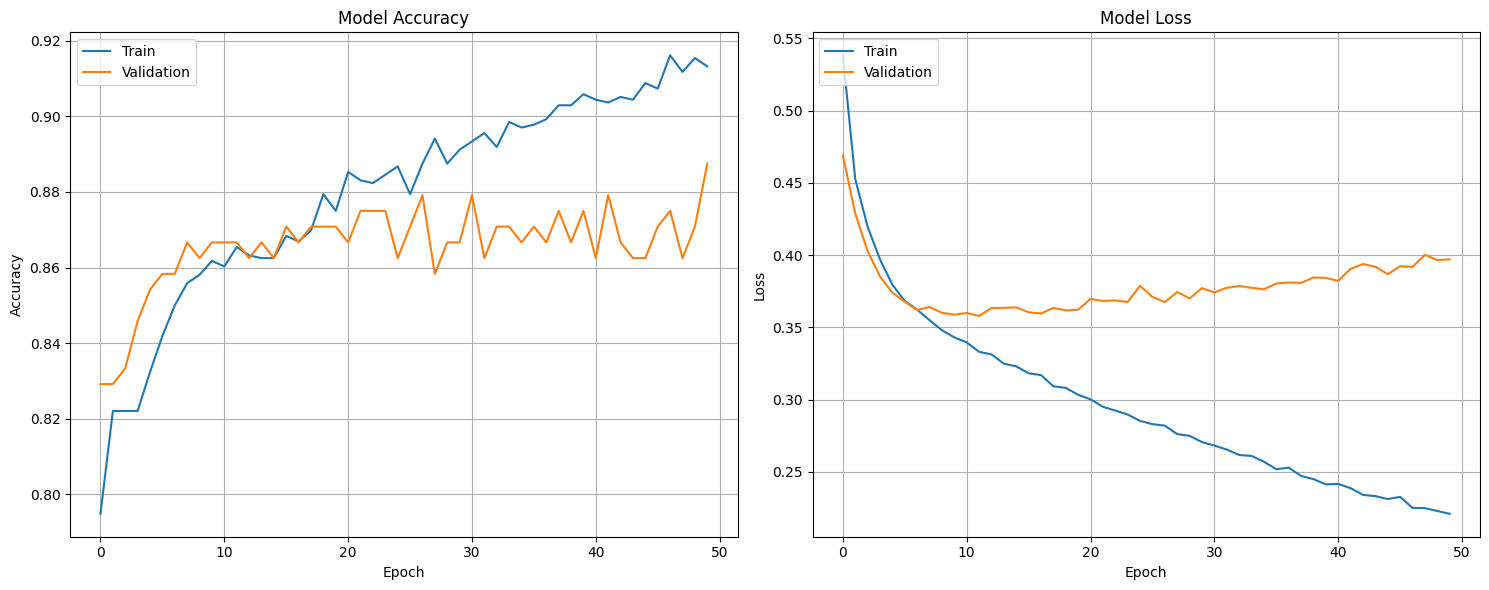

In [32]:
# Train the model
# epochs: Number of times the model will iterate over the entire training dataset.
# batch_size: Number of samples processed per gradient update.
# validation_split: Fraction of the training data to be used as validation data.
# verbose: 0=silent, 1=progress bar, 2=one line per epoch.
history = model.fit(
    X_train_processed, y_train, # Use processed features and original labels
    epochs=50, # Number of passes over the entire dataset
    batch_size=32, # Number of samples per gradient update
    validation_split=0.15, # Use 15% of training data for validation
    verbose=1 # Display training progress
)

print("\nModel training complete.")

# Plot training & validation accuracy and loss values
plt.figure(figsize=(15, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

#6. Evaluate the Model on Test Data
After training, we evaluate the model's performance on the completely unseen test data.

In [33]:
# Evaluate the model on the test set
print("\nEvaluating model on test data...")
# model.evaluate returns loss and metrics specified in model.compile
loss, accuracy, precision, recall = model.evaluate(X_test_processed, y_test, verbose=0)

print(f'\nTest Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')

# Make predictions on the test set
# model.predict returns probabilities for the positive class (churn)
y_pred_probs = model.predict(X_test_processed)

# Convert probabilities to binary class predictions (0 or 1) using a threshold (e.g., 0.5)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

print("\nFirst 5 true labels:")
print(y_test.values[:5]) # .values to get numpy array from pandas Series
print("First 5 predicted probabilities:")
print(y_pred_probs[:5].flatten()) # .flatten() to remove extra dimension
print("First 5 predicted classes:")
print(y_pred_classes[:5].flatten())


Evaluating model on test data...

Test Loss: 0.4372
Test Accuracy: 0.8450
Test Precision: 0.6286
Test Recall: 0.3099
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

First 5 true labels:
[0 0 0 0 0]
First 5 predicted probabilities:
[0.0026291  0.28624776 0.06878679 0.00631426 0.05641032]
First 5 predicted classes:
[0 0 0 0 0]


#7. Calculate and Visualize Comprehensive Evaluation Metrics
For binary classification, especially with potential class imbalance, a single accuracy score is often insufficient. Precision, Recall, F1-score, ROC AUC, and the Confusion Matrix provide a more complete picture.


--- Scikit-learn Evaluation Metrics ---
Accuracy: 0.8450
Precision: 0.6286
Recall: 0.3099
F1-Score: 0.4151
ROC AUC Score: 0.7641

Confusion Matrix:
[[316  13]
 [ 49  22]]


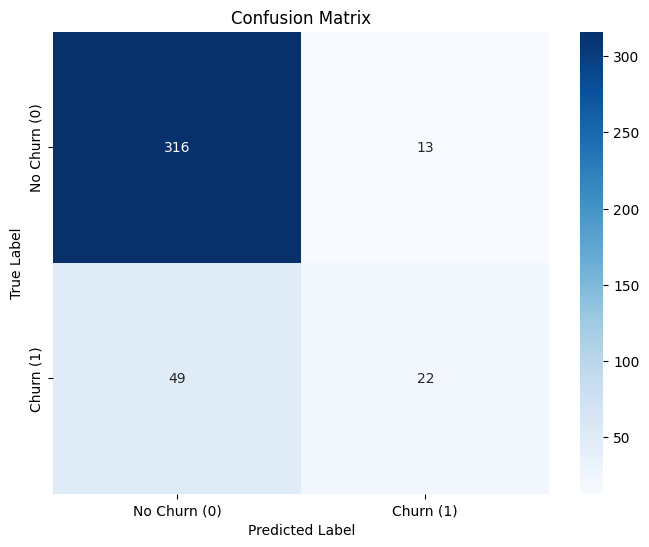


--- Classification Report ---
              precision    recall  f1-score   support

    No Churn       0.87      0.96      0.91       329
       Churn       0.63      0.31      0.42        71

    accuracy                           0.84       400
   macro avg       0.75      0.64      0.66       400
weighted avg       0.82      0.84      0.82       400



In [34]:
# Calculate additional classification metrics from scikit-learn
test_accuracy_sk = accuracy_score(y_test, y_pred_classes)
test_precision_sk = precision_score(y_test, y_pred_classes) # Default for binary
test_recall_sk = recall_score(y_test, y_pred_classes)       # Default for binary
test_f1_sk = f1_score(y_test, y_pred_classes)               # Default for binary
test_roc_auc = roc_auc_score(y_test, y_pred_probs)          # ROC AUC score using probabilities

print(f'\n--- Scikit-learn Evaluation Metrics ---')
print(f'Accuracy: {test_accuracy_sk:.4f}')
print(f'Precision: {test_precision_sk:.4f}')
print(f'Recall: {test_recall_sk:.4f}')
print(f'F1-Score: {test_f1_sk:.4f}')
print(f'ROC AUC Score: {test_roc_auc:.4f}') # Area Under the Receiver Operating Characteristic Curve

# Confusion Matrix
# A table that shows the number of correct and incorrect predictions for each class.
cm = confusion_matrix(y_test, y_pred_classes)
print(f'\nConfusion Matrix:\n{cm}')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'], yticklabels=['No Churn (0)', 'Churn (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (combines precision, recall, f1-score for each class)
print('\n--- Classification Report ---')
print(classification_report(y_test, y_pred_classes, target_names=['No Churn', 'Churn']))

#8. Save and Load the Model

In [35]:
# Save the model
model_path = 'churn_nn_model.h5' # HDF5 format is common for Keras models
model.save(model_path)
print(f"\nModel saved to {model_path}")

# Load the model (demonstration)
loaded_model = keras.models.load_model(model_path)
print("\nModel loaded successfully.")

# Verify the loaded model's performance (should be identical to the original model's test performance)
loss_loaded, accuracy_loaded, _, _ = loaded_model.evaluate(X_test_processed, y_test, verbose=0)
print(f'Loaded Model Test Accuracy: {accuracy_loaded:.4f}')


Model saved to churn_nn_model.h5



Model loaded successfully.
Loaded Model Test Accuracy: 0.8450
